# Resolución numérica de ecuaciones no lineales

Autor: Pedro González Rodelas

Fecha de la primera versión: 10/08/2017

Sucesivas revisiones: 15/08/2017, 19/10/2018, 15,22/03/2020 y 20/04/2020

Fecha de la última revisión: 17-18, 24/03/2021

Notebook adaptado y extendido a partir del notebook original realizado con Mathematica e incluido en el libro:

"Análisis Numérico con Mathematica" de Ariel Ciencia. ISBN: 

In [732]:
# Cargando el fichero version_information.py
# alojado el directorio de trabajo actual
# podremos comprobar las versiones concretas
# tanto del intérprete de Python, como de los
# módulos empleados.

%reload_ext version_information

%version_information numpy, matplotlib, sympy

Software versions
Python 3.8.10 64bit [GCC 9.4.0]
IPython 8.10.0
OS Linux 5.15.0 67 generic x86_64 with glibc2.29
numpy 1.24.2
matplotlib 3.7.0
sympy 1.11.1
Mon Mar 20 19:47:45 2023 CET

En esta práctica vamos a usar varios procedimientos computacionales ya implementados en alguno de los módulos o librerías de Python, así como revisar e implementar nosotros mismos otros métodos numéricos varios para calcular o aproximar las raíces, también llamados ceros, de una cierta función $f(x)$ en un intervalo $[a,b]$ de la recta real.

## Carga de los módulos y funciones empleadas

Antes de empezar a realizar cualquier cálculo numérico o simbólico debemos de cargar los correspondientes módulos de Python que implementan la mayoría de funciones y procedimientos necesarios para ello: NumPy y SymPy, que serán cargados con los pseudónimos np y sp, respectivamente. Además cargaremos también el submódulo PyPlot, del paquete MatPlotlib, que nos permitirá realizar las representaciones gráficas que nos ayudarán a visualizar todo el proceso.

In [733]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [734]:
import sympy as sp
# sp.init_printing()   
# En la versión 1.4 de Sympy conviene dejar comentada esta linea anterior

In [735]:
from numpy import sign
# Esta función de NumPy nos permitirá calcular el signo de un número

In [736]:
from decimal import *
# Este módulo nos permitirá trabajar con un precisión determinada
getcontext()

Context(prec=5, rounding=ROUND_HALF_EVEN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[Inexact, FloatOperation, Rounded], traps=[InvalidOperation, DivisionByZero, Overflow])

In [737]:
mporig = getcontext().prec
mporig  # Esta sería la precisión con la que se trabaja por defecto

5

In [738]:
def mychop(expr, *, max=10**(-16)):
    ''' Esta función redondea por cero cualquier número más
    pequeño a la cantidad máxima indicada'''
    if abs(expr) > max:
      return expr 
    else:
      return 0

In [739]:
mychop(8.000000000000000000001) 
#Este número lo trunca, no porque el método actúe sobre él, sino porque el ordenador no almacena más de 16 cifras significativas

8.0

In [740]:
mychop(0.00001)

1e-05

In [741]:
mychop(10**(-16))

0

In [742]:
chop_vec = np.vectorize(mychop) # esta variante vectorizada será muy
# útil cuando tengamos que aplicar la función mychop a listas o arrays

En un primer momento podríamos intentar tratar de obtener simbólicamente la o las posibles raíces.

Para ello debemos comenzar definiendo una variable simbólica gracias a la orden Symbol, perteneciente al módulo de cálculo simbólico SymPy, que recordamos que se ha cargado previamente con el alias sp, así como la función con la que vamos a trabajar, tanto de manera simbólica como numérica. 

In [743]:
x = sp.Symbol('x')

También definiremos la misma expresión de dicha función pero usando tanto una definición como función simbólica (cargando la función exponencial a partir del módulo simbólico SymPy) como numérica (utilizando esta vez la implementación de la exponencial que viene incluida en el módulo NumPy). Posteriormente, intercambiaremos la definición de nuestra función $f(x)$, usando una definición u otra, según nos convenga.

In [744]:
def fsym(x):
    ''' función sp.exp(x)-3'''
    return sp.exp(x)-3

In [745]:
def fnum(x):
    ''' función np.exp(x)-3'''
    return np.exp(x)-3

In [746]:
def f(x):
    '''Versión simbólica de la función'''
    return fsym(x)   

In [747]:
a = 0; b = 2;

In [748]:
f(a),f(b)

(-2, -3 + exp(2))

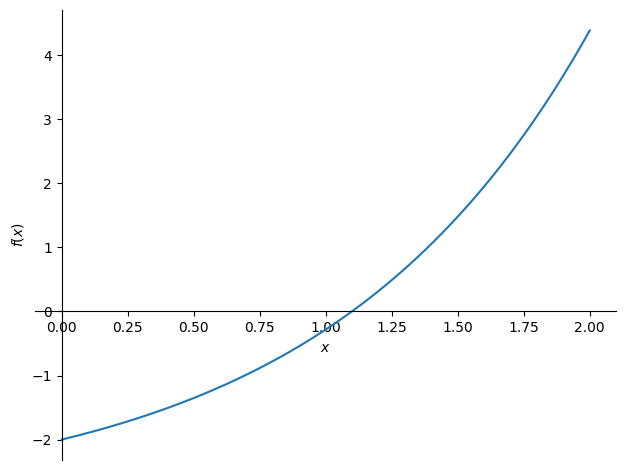

In [749]:
sp.plot(f(x),(x,a,b))

In [750]:
sol_exact = sp.solve(f(x),x)[0]
print(sol_exact)

log(3)


In [751]:
sol_exact.evalf()

1.09861228866811

No obstante, es bien sabido que no siempre es posible, ni fácil, encontrar simbólicamente las raices de ciertas ecuaciones de tipo trascendente o incluso polinómicas de grado superior. Por ello es habitual y más recomendable emplear algún método numérico para aproximar las posibles raices de las ecuaciones de tipo no lineal. En todo caso, lo primero que tenemos que hacer es estudiar si efectivamente dicha ecuación puede tener soluciones reales y comprobar que se dan las condiciones adecuadas para poder aplicar el método correspondiente. Muchas veces lo mejor será ayudarnos previamente,  siempre que podamos, con una representación gráfica de la función en un intervalo apropiado. De esta manera, la ecuación tendrá una interpretación geométrica muy clara, como la búsqueda de los puntos de corte de la gráfica de dicha función con el eje $ OX$.

In [752]:
?f 
# esto nos permitirá mostrar la documentación que hemos incluido
# entre triples comillas en la definición

Signature: f(x)
Docstring: Versión simbólica de la función
File:      /tmp/ipykernel_213622/4277971234.py
Type:      function

In [753]:
help(f)

Help on function f in module __main__:

f(x)
    Versión simbólica de la función



In [754]:
a = 0.; b = 2.; 

In [755]:
# ahora nos interesará emplear la versión numérica de la función
# por lo que nos convendrá intercambiar la definición de f(x)
def f(x):
    '''Versión numérica de la función'''
    return fnum(x)

In [756]:
nxx = 100;
xx = np.linspace(a,b,nxx)
#Return evenly spaced numbers over a specified interval.
yy = f(xx)   

In [757]:
xx

array([0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
       0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
       0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
       0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
       0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
       0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
       0.60606061, 0.62626263, 0.64646465, 0.66666667, 0.68686869,
       0.70707071, 0.72727273, 0.74747475, 0.76767677, 0.78787879,
       0.80808081, 0.82828283, 0.84848485, 0.86868687, 0.88888889,
       0.90909091, 0.92929293, 0.94949495, 0.96969697, 0.98989899,
       1.01010101, 1.03030303, 1.05050505, 1.07070707, 1.09090909,
       1.11111111, 1.13131313, 1.15151515, 1.17171717, 1.19191919,
       1.21212121, 1.23232323, 1.25252525, 1.27272727, 1.29292929,
       1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
       1.41414141, 1.43434343, 1.45454545, 1.47474747, 1.49494

In [758]:
yy

array([-2.        , -1.97959254, -1.95876861, -1.93751972, -1.9158372 ,
       -1.89371218, -1.87113566, -1.8480984 , -1.82459101, -1.8006039 ,
       -1.77612727, -1.75115113, -1.7256653 , -1.69965936, -1.67312271,
       -1.64604451, -1.61841371, -1.59021904, -1.56144899, -1.53209182,
       -1.50213553, -1.47156792, -1.4403765 , -1.40854854, -1.37607106,
       -1.34293079, -1.30911421, -1.27460753, -1.23939664, -1.2034672 ,
       -1.16680452, -1.12939366, -1.09121933, -1.05226596, -1.01251765,
       -0.97195818, -0.93057099, -0.8883392 , -0.84524556, -0.80127249,
       -0.75640204, -0.7106159 , -0.66389538, -0.61622142, -0.56757455,
       -0.51793492, -0.46728227, -0.41559592, -0.3628548 , -0.30903736,
       -0.25412164, -0.19808523, -0.14090526, -0.08255839, -0.02302081,
        0.03773178,  0.09972417,  0.16298168,  0.22753011,  0.2933958 ,
        0.36060565,  0.42918709,  0.49916809,  0.57057723,  0.64344365,
        0.71779709,  0.79366789,  0.87108703,  0.95008609,  1.03

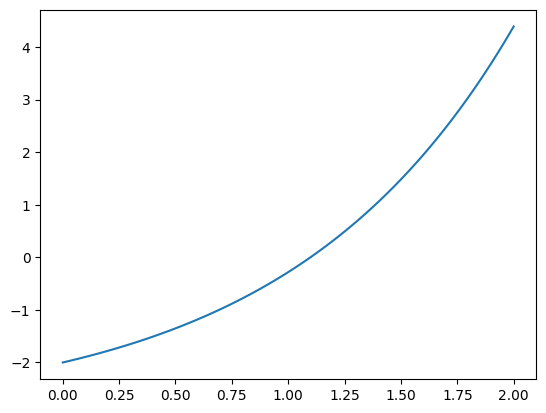

In [759]:
plt.plot(xx,yy);

Con la ayuda de este gráfico standard de MatPlotlib (en su API simplificada tipo MATLAB) podemos intuir donde podría estar el punto de corte de dicha gráfica con el eje $Ox$, no obstante convendría ajustar alguna de las opciones por defecto de los gráficos de MatPlotlib, usando más bien su API tipo orientada a objetos, como veremos a continuación, con el objeto de poder controlar la posición exacta de los ejes, por ejemplo.

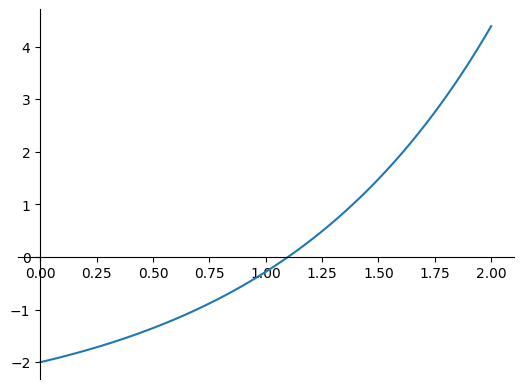

In [760]:
fig, ax = plt.subplots()  # de esta forma generamos una instancia
# de la clase figura, con sus correspondientes ejes 
# y con posibilidad de incluir varios gráficos en ella

# estas opciones evitan que se dibujen
ax.spines['right'].set_color('none')   # tanto el borde derecho
ax.spines['top'].set_color('none') # como el superior del gráfico
 
# mientras que las opciones siguientes sirven
ax.xaxis.set_ticks_position('bottom')
# para fijar la posición de las marcas en la parte inferior 
ax.spines['bottom'].set_position(('data',0)) 
# y situar el eje Ox en la recta horizontal y=0

# y estas para fijar la posición de las marcas 
ax.yaxis.set_ticks_position('left')  # a la izquierda del eje Oy
ax.spines['left'].set_position(('data',0))   
# y situar éste en la recta vertical x=0

# ahora es cuando generamos el gráfico en sí
ax.plot(xx, yy); # como una instancia de la clase ejes

Vemos claramente que esta función posee una raíz, también llamado cero o punto de corte con el eje $Ox$ cerca del valor real $1.0$ y en todo caso comprendido entre los valores $1.0$ y $1.5$. Esta simple idea de ir acotando el cero de una función *contínua* entre dos valores reales, entre los cuales se encuentre el punto de corte con el eje $Ox$, podría servirnos para aproximar cada vez más dicho cero o raíz, pudiéndose realizar todo este proceso de manera gráfica, como veremos a continuación.

In [761]:
a_1 = 1.0; b_1 = 1.25; 
xxbis = np.linspace(a_1,b_1,nxx)
yybis = f(xxbis)

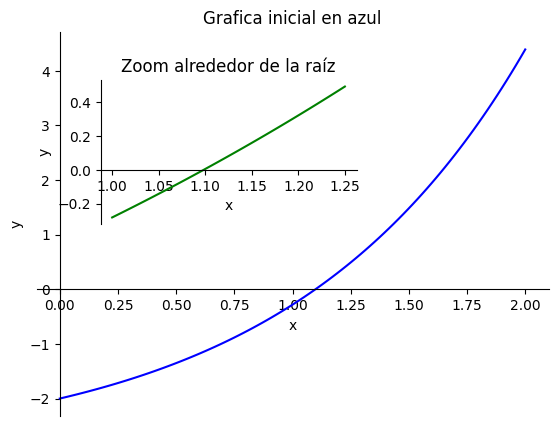

In [762]:
fig = plt.figure()

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # Ejes principales
ax2 = fig.add_axes([0.2, 0.5, 0.4, 0.3]) # Ejes insertados

ax1.spines['right'].set_color('none')   
ax1.spines['top'].set_color('none') 
ax1.xaxis.set_ticks_position('bottom') 
ax1.spines['bottom'].set_position(('data',0))  
ax1.yaxis.set_ticks_position('left')
ax1.spines['left'].set_position(('data',0))

ax2.spines['right'].set_color('none')   
ax2.spines['top'].set_color('none') 
ax2.xaxis.set_ticks_position('bottom') 
ax2.spines['bottom'].set_position(('data',0))  
ax2.yaxis.set_ticks_position('left')
# ax2.spines['left'].set_position(('data',0))

# Figura principal
ax1.plot(xx, yy, 'b')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Grafica inicial en azul')

# Subfigura insertada
ax2.plot(xxbis, yybis, 'g')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Zoom alrededor de la raíz');

Repita usted mismo a continuación el proceso varias veces, hasta que consiga acotar el cero de esta misma función, con un error inferior a una milésima por ejemplo, modificando convenientemente los límites $a_1$ y $b_1$ del subintervalo considerado para representar sólamente un zoom de su gráfica inicial en el subintervalo adecuado.

In [763]:
a_1 = 1.098; b_1 = 1.099; 
xxbis = np.linspace(a_1,b_1,nxx)
yybis = f(xxbis)

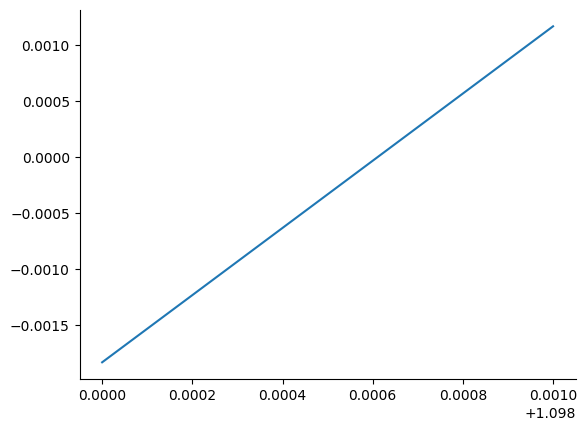

In [764]:
fig, ax = plt.subplots() 
ax.spines['right'].set_color('none')   
ax.spines['top'].set_color('none') 
ax.xaxis.set_ticks_position('bottom')
# ax.spines['bottom'].set_position(('data',0))  
ax.yaxis.set_ticks_position('left')    
ax.plot(xxbis, yybis); 

Pero esta misma idea también es la base de otros métodos numéricos. En todos ellos partimos de que se dan las hipótesis del conocido teorema de Bolzano para la función $f$ en cierto intervalo de su dominio de definición; esto es, continuidad en dicho intervalo y cambio de signo para los valores de la función en los extremos del mismo. Así podremos  tener asegurada la existencia de al menos una raíz de la ecuación $f(x)=0$ en dicho intervalo.

En esta misma idea se basan los denominados métodos de *bisección* y el de *regula-falsi*, que chequean en todo momento que el preceptivo cambio de signo entre los valores de la función en los extremos del subintervalo considerado en cada iteración del método sigue teniendo lugar.

### Método de búsqueda incremental

Por otra parte, el denominado *método de búsqueda incremental* también va chequeando valores de la función continua en puntos sucesivos $x_i < x_{i+1} = x_i + \Delta x $ para un cierto valor adecuado del incremento $\Delta x > 0$. De manera que , si la función tiene ceros en el intervalo de partida y elegimos adecuadamente este valor del incremento, podremos localizar y aislar al menos algunos de ellos con este rudimentario procedimiento, aunque por supuesto que también adolece de algún que otro inconveniente:
* Es posible que pasemos por alto sin detectar varios ceros demasiado próximos, si el incremento $\Delta x$ no es lo suficientemente pequeño.
* Las raíces dobles (ceros que coinciden) no serán detectadas por este tipo de procedimientos, ya que no necesariamente involucran cambio de signo.
* Ciertas singularidades o discontinuidades de la función pueden dar lugar a incongruencias o falsos ceros, si no se verifica previamente la continuidad de la función en los subintervalos considerados.

Veámos a continuación una posible implementación en forma de módulo o función de este sencillo procedimiento. 

In [765]:
def buscaraiz(f,a,b,dx): 
    x1 = a; x2 = a + dx
    f1 = f(x1); f2 = f(x2)
    while sign(f1) == sign(f2):
        if x1 >= b: return None,None   # se podría cambiar por x2 >= b
        x1 = x2;  f1 = f2
        x2 = x1 + dx; f2 = f(x2)
    else:
        return x1,x2

In [766]:
# recordemos qué función tenemos definida en este momento
?f 

Signature: f(x)
Docstring: Versión numérica de la función
File:      /tmp/ipykernel_213622/2095883551.py
Type:      function

In [767]:
a,b # así como el intervalo del que partíamos

(0.0, 2.0)

In [768]:
sign(f(a)),sign(f(b)) # al haber cargado la función signo de NumPy
# ya podemos chequear directamente si hay cambio de signo en el 
# intervalo de partida [a,b]

(-1.0, 1.0)

In [769]:
sign(f(a)) != sign(f(b)) # y utilizar la expresión lógica 
# correspondiente, con sólo dos posibles valores: True o False

True

Empecemos realizando ahora una búsqueda incremental con paso de una décima (dx = 0.1) y sigamos refinando la búsqueda con pasos correspondientes a una centésima (dx = 0.01), una milésima (dx = 0.001), etc. Otra idea útil sería tomar como aproximación de la raíz el punto medio de cada uno de los sucesivos intervalos en los que hayamos encajado la misma. Aunque ésto no garantizará ni mucho menos que hayamos conseguido siempre aproximar dicha raíz con una décima, centésima o milésima exacta, sí que tendremos asegurado que el error cometido será inferior a dicho valor del incremento dx.

In [770]:
a1,b1 = buscaraiz(f,a,b,0.1) # búsqueda incremental con décimas 
print(a1,b1)
print ((a1+b1)/2)

0.9999999999999999 1.0999999999999999
1.0499999999999998


In [771]:
a2,b2 = buscaraiz(f,a1,b1,0.01) # búsqueda incremental con centésimas 
print(a2,b2)
print ((a2+b2)/2)

1.0899999999999999 1.0999999999999999
1.0949999999999998


In [772]:
a3,b3 = buscaraiz(f,a2,b2,0.001) # búsqueda incremental con milésimas
print(a3,b3)
print ((a3+b3)/2)

1.097999999999999 1.0989999999999989
1.098499999999999


También vamos a guardar dicho procedimiento en un fichero de Python 'buscaraiz.py' en nuestro directorio de trabajo, por si queremos usarlo posteriormente en una sesión de Python desde la terminal o bien desde cualquier sistema integrado de desarrolo (IDE, de las siglas en inglés) como Spyder, por ejemplo. 

In [773]:
%pwd # esta orden de IPython se traduciría en la correspondiente
# del sistema operativo que nos muestra dicho directorio de trabajo

'/home/lauralazaro/Escritorio/DGIIM/TERCERO/MNII'

In [774]:
# %ls # esta orden de IPython se traduciría en la correspondiente
# del sistema operativo que nos muestra los ficheros que allí hay

In [775]:
%%writefile buscaraiz.py
# -*- coding: UTF-8 -*-
## modulo buscaraiz
'''
x1,x2 = buscaraiz(f,a,b,dx)
buscará dentro del intervalo [a,b] en incrementos de dx una acotación
de la forma [x1,x2] de la raíz más pequeña de f(x) en dicho intervalo.
Se devolverá x1 = x2 = None en caso de no encontrarse ninguna.
'''
# global f,a,b,dx

def buscaraiz(f,a,b,dx): 
    x1 = a; x2 = a + dx
    f1 = f(x1); f2 = f(x2)
    while sign(f1) == sign(f2):
        if x2 >= b: return None,None   # hemos cambiado x1 por x2
        x1 = x2;  f1 = f2
        x2 = x1 + dx; f2 = f(x2)
    else:
        return x1,x2
print(x1,x2)

Overwriting buscaraiz.py


In [776]:
# %ls *.py # comprobamos a continuación que tenemos el correspondiente
# fichero que acabamos de generar con la extensión .py

In [777]:
!type buscaraiz.py 
# esta orden de IPython ya es una orden directa del correspondiente
# sistema operativo que nos muestra el contenido del fichero indicado
# y por lo tanto habria que adaptarla, dependiendo del SO que estemos
# usando, por ejemplo !cat para Unix/Linux/Mac y !type para Windows

/bin/bash: línea 0: type: buscaraiz.py: no se encontró


Por otra parte, en todos y cada uno de los métodos que se presentan a continuación será absolutamente necesario evitar la posibilidad de entrar en un posible "bucle infinito", que dejaría bloqueado al programa e incluso al sistema operativo del ordenador en el caso de que no consigamos interrumpir los cálculos (mediante el correspondiente comando en el menú $<$Kernel$>$-$<$Interrupt$>$ de iPython).

Tendremos pues que idear unos ciertos criterios de parada, de manera que el proceso se detenga cuando los resultados obtenidos se diferencien en menos de un cierto valor, que será la tolerancia o error máximo permitido, **tol**; o bien, cuando sean realizadas un número máximo de iteraciones, **nmax**, que indicaremos de antemano.
 
Por otro lado, para la comprobación de una posible raíz exacta de la ecuación, se ha implementado una condición del tipo 
$|f(c)|<\epsilon$, siendo $\epsilon =10^{-\sigma }$ con $\sigma = 16$, que suele ser la precisión de la máquina cuando se trabaja en "doble precisión", que es lo habitual en cálculo numérico.

Esto es debido a que, a no ser que se efectuaran todos los cálculos de forma simbólica (con la consecuente ralentización del proceso), siempre se realizan con una precisión limitada, y, por lo tanto, hay que considerar de esta manera la posibilidad de encontrar un valor de la raíz, afectado siempre por errores de redondeo, muy próximo a la raíz exacta de la ecuación. 

In [778]:
mp = 16;
getcontext().prec = mp

In [779]:
prec = 10**(-mp)
prec

1e-16

También se ofrece la posibilidad de solicitar que se calculen o simplemente se muestren todos los resultados con un número de cifras significativas determinado por el usuario, que en todo caso debe ser igual o inferior al valor de la  Precision de la Máquina con la que se trabaje.

In [780]:
cifras = 5  # Número de cifras con el que queremos calcular 
getcontext().prec = cifras # y presentar los resultados

In [781]:
tol = 10**(-cifras)
tol

1e-05

In [782]:
nmax = 100  # Número máximo de iteraciones

## Algoritmos de resolución numérica de ecuaciones más empleados

### Métodos de Bisección y regula-falsi

A continuación tenemos la implementación del método de bisección (también llamado de bipartición).  Para obtener
el algoritmo de regula-falsi bastará sustituir la línea de programa donde se calcula el valor de  $c$ como el punto medio del intervalo por alguna de las siguientes asignaciones 

$$c=b-\frac{(a-b)f(b)}{f(a)-f(b)} =a-\frac{(b-a)f(a)}{f(b)-f(a)}$$

que corresponderían con el punto de corte de la recta secante con el eje  $Ox$.

Recuerde también que cuando se emplee este programa para aproximar una raíz de la ecuación     $f(x)=0$ se debe elegir
un intervalo de partida adecuado en cada caso, de manera que se verifiquen la hipótesis del teorema de Bolzano.

In [783]:
a0 = a; b0 = b;   # conviene guardar una copia de los extremos del 
# intervalo original, ya que los iremos modificando en cada iteración
a,b

(0.0, 2.0)

Ejecutemos en primer lugar el algoritmo usando la doble precisión habitual de la máquina en coma flotante (usando 64 bits para almacenar los números de la clase `float`), que equivale a trabajar con unas 16 cifras significativas para todos los cálculos.

In [784]:
# Trabajando con la precisión habitual en coma flotante
niter = 0; sale =''
for k in range(nmax):
    niter = niter + 1;
    c = a + (b-a)/2 # equivalente a c = (a+b)/2
    if abs(f(c)) < prec:
        sale = 'precision'
        break
    if sign(f(a)) != sign(f(c)):
        b = c
    else:
        a = c
    if b-a < tol:
        sale = 'tolerancia'
        break
        
if sale == 'precision':
    print('Posiblemente solución exacta: ',c)
elif niter < nmax:
    print('Aproximación solicitada: ',c)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta, ', sol_exact, ", con decimales  ", sol_exact.evalf() )
print('Número total de iteraciones ', niter)

a = a0; b = b0 # Restauramos los valores originales de a y b

Aproximación solicitada:  1.0986099243164062
Solución exacta,  log(3) , con decimales   1.09861228866811
Número total de iteraciones  18


In [785]:
sp.N(c,cifras), c, sp.N(sol_exact)

(1.0986, 1.0986099243164062, 1.09861228866811)

Visualicemos un pequeño video en formato MP4 que se ha generado previamente con Python mostrando este proceso de aproximación mediante el algoritmo de bisección, y que con la siguiente celdilla de IPython podemos ahora incrustar dentro de este notebook.

In [786]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="video_Bisección.mp4" type="video/mp4">
</video></div>""")

Repitamos ahora el mismo algoritmo, pero usando una precisión y número de cifras significativas concreto, indicado por el valor de la variable `cifras`. Para ello convirtamos previamente los valores extremos del intervalo al formato decimal determinado por la precisión que hemos forzado en este caso.

In [787]:
a,b = Decimal(a),Decimal(b)

In [788]:
a,b

(Decimal('0'), Decimal('2'))

In [789]:
# Ahora con la precisión asociada al nº de cifras solicitadas
niter = 0; sale =''
getcontext().prec = cifras
for k in range(nmax):
    niter = niter + 1;
    c = a + (b-a)/2 # equivalente a c = (a+b)/2
    if abs(f(c)) < prec:
        sale = 'precision'
        break
    if sign(f(a)) != sign(f(c)):
        b = c
    else:
        a = c
    if b-a < tol:
        sale = 'tolerancia'
        break

if sale == 'precision':
    print('Posiblemente solución exacta: ',c)
elif niter < nmax:
    print('Aproximación solicitada: ',c)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', cifras, ' cifras significativas', sol_exact.evalf(n=cifras))
print('Número total de iteraciones ', niter)

a = a0; b = b0 # Restauramos los valores originales de a y b
getcontext().prec = mporig # así como la precisión por defecto

Posiblemente solución exacta:  1.0986
Solución exacta con  5  cifras significativas 1.0986
Número total de iteraciones  11


In [790]:
# Ahora con la precisión asociada al nº de cifras solicitadas -- VERSIÓN REGULA-FALSI
niter = 0; sale =''
getcontext().prec = cifras
for k in range(nmax):
    niter = niter + 1;
    c = b-(((a-b)*f(b))/(f(a)-f(b)))
    if abs(f(c)) < prec:
        sale = 'precision'
        break
    if sign(f(a)) != sign(f(c)):
        b = c
    else:
        a = c
    if b-a < tol:
        sale = 'tolerancia'
        break

if sale == 'precision':
    print('Posiblemente solución exacta: ',c)
elif niter < nmax:
    print('Aproximación solicitada: ',c)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', cifras, ' cifras significativas', sol_exact.evalf(n=cifras))
print('Número total de iteraciones ', niter)

a = a0; b = b0 # Restauramos los valores originales de a y b
getcontext().prec = mporig # así como la precisión por defecto

Se llegó al número máximo de iteraciones
Solución exacta con  5  cifras significativas 1.0986
Número total de iteraciones  100


In [791]:
type(a), type(b), type(c), type(sol_exact)

(float, float, numpy.float64, log)

Vemos cómo, en efecto, se ha debido de  cumplir uno de los criterios de parada impuestos en un  número finito de iteraciones. Así pues,  el método ha sido capaz de calcular una aproximación de la raíz de la ecuación con algunas cifras decimales exactas;
esto lo podemos concluir en este caso ya que una variación pequeña, que ha sido el error máximo cometido o tolerancia, podría
cambiar como mucho  alguna de las últimas cifras decimales en una unidad y vemos que, en muchos de los casos, esto no afectaría por
errores de redondeo a las otras.

**_Ejercicio:_** Modifique cualquiera de estos códigos con el objeto de implementar el conocido algoritmo de regula-falsi, en el que se obtiene el punto $c$ no como el punto medio entre $a$ y $b$, sino como el punto de corte con el eje $Ox$ de la recta que une los puntos $(a,f(a))$ y $(b,f(b))$, tal y como se muestra también en el siguiente método de la secante.

### Método de la secante

A continuación tenemos la implementación del método de la secante. Es parecido al de regula-falsi, salvo que ahora se construye iterativamente
una sucesión de valores 
$$x_{k+1}=x_k-\frac{x_k-x_{k-1}}{f\left(x_k\right)-f\left(x_{k-1}\right)}f\left(x_k\right)\\
=x_{k-1}-\frac{x_k-x_{k-1}}{f\left(x_k\right)-f\left(x_{k-1}\right)}f\left(x_{k-1}\right)$$ 
sin realizar la comprobación de cambio de signo. 

Ahora bien, lo mismo que ocurría al emplear el método de bisección en la sección anterior,
debemos de idear algún criterio de parada cuando programamos cualquier método iterativo. Lo que haremos ahora, al no poder controlar de
forma tan clara como en el método de bisección el error absoluto cometido,  es fijarnos en la diferencia entre dos iteraciones consecutivas,
parando el proceso cuando ésta sea inferior a la tolerancia prefijada, **tol**; también fijaremos un número máximo de iteraciones
a realizar, en caso de que dicha tolerancia sea dificil de alcanzar en un número de iteraciones razonable.

In [792]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="video_Secante.mp4" type="video/mp4">
</video></div>""")

In [793]:
a,b

(0.0, 2.0)

In [794]:
mp, tol, prec


(16, 1e-05, 1e-16)

In [795]:
# Trabajando con la precisión habitual en coma flotante
x0 = a; x1 = b; sale =''
niter = 0; # getcontext().prec = mp
for k in range(nmax):
    niter = niter + 1;
    c = x1 - (x0-x1)/(f(x0)-f(x1))*f(x1) 
    if abs(f(c)) < prec:
        sale = 'precision'
        break
    else:
        x1,x0 = c,x1
    if abs(x1-x0) < tol:
        sale = 'tolerancia'
        break

if sale == 'precision':
    print('Posiblemente solución exacta: ', c)
elif niter < nmax:
    print('Aproximación solicitada: ', c)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', cifras, ' cifras significativas', sol_exact.evalf(n=cifras))
print('Número total de iteraciones ', niter)

# getcontext().prec = mporig # Se restaura la precisión por defecto

Aproximación solicitada:  1.0986122886490808
Solución exacta con  5  cifras significativas 1.0986
Número total de iteraciones  7


In [796]:
cifras, mp, mporig

(5, 16, 5)

In [797]:
# Ahora con la precisión asociada al nº de cifras solicitadas
getcontext().prec = cifras     
x0 = Decimal(a); x1 = Decimal(b);
niter = 0; sale =''

for k in range(nmax):
    niter = niter + 1;
    c = x1 - (x0-x1)/(f(x0)-f(x1))*f(x1)  
    if abs(f(c)) < prec:
        sale = 'precision'
        break
    else:
        x1,x0 = c,x1
    if abs(x1-x0) < tol:
        sale = 'tolerancia'
        break

if sale == 'precision':
    print('Posiblemente solución exacta: ',c)
elif niter < nmax:
    print('Aproximación solicitada: ', c)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', cifras, ' cifras significativas', sol_exact.evalf(n=cifras))
print('Número total de iteraciones ', niter)

getcontext().prec = mporig # Se restaura la precisión por defecto

Posiblemente solución exacta:  1.0986
Solución exacta con  5  cifras significativas 1.0986
Número total de iteraciones  6


In [798]:
# Ahora con la precisión por defecto del módulo Decimal
getcontext().prec = mporig
x0 = Decimal(a); x1 = Decimal(b);
niter = 0; sale =''

for k in range(nmax):
    niter = niter + 1; 
    c = x1 - (x0-x1)/(f(x0)-f(x1))*f(x1)
    if abs(f(c)) < prec:
        sale = 'precision'
        break
    else:
        x1,x0 = c,x1
    if abs(x1-x0) < tol:
        sale = 'tolerancia'
        break

if sale == 'precision':
    print('Posiblemente solución exacta: ',Decimal(c))
elif niter < nmax:
    print('Aproximación solicitada: ',Decimal(c))
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', mporig, ' cifras significativas', sol_exact.evalf(n=mporig))
print('Número total de iteraciones ', niter)

getcontext().prec = mporig # Se restaura la precisión por defecto

Posiblemente solución exacta:  1.0986
Solución exacta con  5  cifras significativas 1.0986
Número total de iteraciones  6


### Métodos de Whittaker y Newton-Rapshon

Vamos a implementar en esta sección el llamado método de Whittaker que, a partir de un valor inicial $x_0$, utiliza en principio rectas
con pendiente fijada para calcular el punto de corte de éstas con el eje $Ox$ para aproximar la raíz buscada. No obstante, empleando
el programa resultante y permitiendo variar dichas pendientes, ajustándose a las de la propia función $f$ ($m=f'\left(x_k\right)$, $k\geq 0$, para que sean las de la recta tangente en
el punto $\left(x_k,f\left(x_k\right)\right)$) obtendríamos el conocido método de  [Newton-Raphson](https://es.wikipedia.org/wiki/Método_de_Newton).

También se verá que para que este método funcione correctamente será necesario que la derivada de la función no esté próxima a cero,
al menos en cierto entorno de la raíz, ya que de lo contrario se podría producir una división entre cero o bien la creación
de enormes errores de redondeo al dividir entre cantidades muy pequeñas.

Sigamos pues con el ejemplo que teníamos desde el principio de la práctica, e intentemos representar gráficamente todo este proceso, pero también vamos a necesitar evaluar la función derivada de la función de partida. Para ello también podemos aprovechar la potencia de cálculo simbólico de Python, a través del módulo SymPy, para ayudarnos a calcular la función derivada. No obstante, para poder realizar los cálculos y aproximaciones numéricas posteriores, convendrá definir ambas funciones, tanto la función $f$ como su derivada, empleando las versiones de NumPy de las correspondientes expresiones.  

In [799]:
x

x

In [800]:
def f(x):
    ''' Versión simbólica de la función '''
    return fsym(x)    

In [801]:
f(x),sp.diff(f(x),x)

(exp(x) - 3, exp(x))

In [802]:
def df(x):
    ''' función sp.exp(x)'''
    return sp.exp(x)

In [803]:
a = 0
b = 2

In [804]:
f(a),df(a)

(-2, 1)

In [805]:
x0 = a

In [806]:
f(x0), df(x0)

(-2, 1)

In [807]:
?f

Signature: f(x)
Docstring: Versión simbólica de la función 
File:      /tmp/ipykernel_213622/759724508.py
Type:      function

In [808]:
x0

0

In [809]:
x1 = x0 - f(x0)/df(x0)
x1

2

In [810]:
m=10; x1 = x0 - f(x0)/m
x1

1/5

In [811]:
abs(f(x1)) < prec

False

In [812]:
prec,tol

(1e-16, 1e-05)

In [813]:
# Ahora con la precisión indicada por mp
getcontext().prec = mp
x0 = Decimal(b); niter = 0; sale =''
m =10;  # pendiente prefijada de las rectas a emplear

for k in range(nmax):
    niter = niter + 1;
    x1 = x0 - f(x0)/m  # método de Whitaker
    # Cambiar m por Decimal(df(x0)) para el de Newton-Raphson
    if abs(x1-x0) < tol:
        sale = 'tolerancia'
        break
    if abs(f(x1)) < prec:
        sale = 'precision'
        break
    else:
        x0 = x1
                
print('sale el programa por ',sale)
if sale == 'precision':
    print('Posiblemente solución exacta: ',x1)
elif niter < nmax:
    print('Aproximación solicitada: ', x1)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', mp, ' cifras significativas', sol_exact.evalf(n=mp))
print('Número total de iteraciones ', niter)

getcontext().prec = mporig # Se restaura la precisión por defecto

sale el programa por  tolerancia
Aproximación solicitada:  1.09863422052086
Solución exacta con  16  cifras significativas 1.098612288668110
Número total de iteraciones  28


In [814]:
# Ahora con la precisión asociada al nº de cifras solicitadas
getcontext().prec = cifras
x0 = Decimal(b); niter = 0; sale =''
m =10;  # pendiente prefijada de las rectas a emplear

for k in range(nmax):
    niter = niter + 1;
    x1 = x0 - f(x0)/m  # método de Whitaker
    # Cambiar m por Decimal(df(x0)) para el de Newton-Raphson
    if abs(x1-x0) < tol:
        sale = 'tolerancia'
        break
    if abs(f(x1)) < prec:
        sale = 'precision'
        break
    else:
        x0 = x1
                
print('sale el programa por ',sale)
if sale == 'precision':
    print('Posiblemente solución exacta: ',x1)
elif niter < nmax:
    print('Aproximación solicitada: ', x1)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', cifras, ' cifras significativas', sol_exact.evalf(n=cifras))
print('Número total de iteraciones ', niter)

getcontext().prec = mporig # Se restaura la precisión por defecto

sale el programa por  tolerancia
Aproximación solicitada:  1.09863422052086
Solución exacta con  5  cifras significativas 1.0986
Número total de iteraciones  28


In [815]:
# Ahora con la precisión asociada al nº de cifras solicitadas -- PRUEBA CON M=4
getcontext().prec = cifras
x0 = Decimal(b); niter = 0; sale =''
m =4;  # pendiente prefijada de las rectas a emplear

for k in range(nmax):
    niter = niter + 1;
    x1 = x0 - f(x0)/m  # método de Whitaker
    # Cambiar m por Decimal(df(x0)) para el de Newton-Raphson
    if abs(x1-x0) < tol:
        sale = 'tolerancia'
        break
    if abs(f(x1)) < prec:
        sale = 'precision'
        break
    else:
        x0 = x1
                
print('sale el programa por ',sale)
if sale == 'precision':
    print('Posiblemente solución exacta: ',x1)
elif niter < nmax:
    print('Aproximación solicitada: ', x1)
else:
    print('Se llegó al número máximo de iteraciones')
print('Solución exacta con ', cifras, ' cifras significativas', sol_exact.evalf(n=cifras))
print('Número total de iteraciones ', niter)

getcontext().prec = mporig # Se restaura la precisión por defecto

sale el programa por  tolerancia
Aproximación solicitada:  1.09861121230481
Solución exacta con  5  cifras significativas 1.0986
Número total de iteraciones  10


Vemos que de esta manera, y repitiendo el mismo proceso, se llega iterativamente a construir una sucesión que, si se dan ciertas condiciones apropiadas, va a converger hacia la verdadera raíz de nuestra ecuación. Para ello habrá que elegir convenientemente tanto el valor de la pendiente $m$ como el del valor inicial $x_0$, ya que basta probar con ciertos valores para darnos cuenta cómo nos aproximamos más y más a la raíz, o por el contrario ocurre todo lo contrario. Animamos al lector a realizar algunos cambios en el valor de $m$ y de $x_0$ en la gráfica anterior y comprobarlo por sí mismo.

In [816]:
getcontext().prec

5

Vemos que, por defecto, aunque normalmente los cálculos se efectuan con una precisión mucho mayor, en este caso sólo se nos presentan
algunas de ellas. 

Visualicemos un pequeño video en formato MP4 que se ha generado previamente con Python mostrando el proceso de aproximación mediante el algoritmo de Newton-Raphson en vez del de Whittaker, y que con la siguiente celdilla de IPython podemos ahora incrustar dentro de este notebook. Nótese que ahora en vez de emplear siempre una recta con pendiente fija, utilizaremos la correspondiente recta tangente, que irá adaptando su pendiente a medida que se va moviendo a lo largo de la gráfica de la función, como se puede ver perfectamente en el siguiente video.

In [817]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="video_Newton-Raphson.mp4" type="video/mp4">
</video></div>""")

### Métodos de iteración funcional: casos particulares de los métodos de Newton-Raphson y Steffensen

En los métodos de iteración funcional lo que se pretende es encontrar un [punto fijo](https://es.wikipedia.org/wiki/Método_del_punto_fijo) de la aplicación  $g:I\to I$ para
cierto subconjunto cerrado de la recta real (no necesariamente acotado) mediante una sucesión de valores $x_{k+1}=g\left(x_k\right), k\geq 0$. En el caso del método de Newton-Raphson, bastará con tomar  $g(x)=x-\frac{f(x)}{f'(x)}$, obteniéndose una convergencia al menos cuadrática.  Lo mismo ocurre con el denominado método de Steffensen, en el que se tomaría $g(x)=x-\frac{f(x)^2}{f(x+f(x))-f(x)}$,
y que no debe confundirse con el método de aceleración de la convergencia del mismo nombre, que se presentará más adelante.

In [818]:
?f

Signature: f(x)
Docstring: Versión simbólica de la función 
File:      /tmp/ipykernel_213622/759724508.py
Type:      function

In [819]:
?df

Signature: df(x)
Docstring: función sp.exp(x)
File:      /tmp/ipykernel_213622/1986639961.py
Type:      function

In [820]:
x = sp.Symbol('x')

In [821]:
def f(x):
    ''' función sp.exp(x)-3'''
    return sp.E**x-3

In [822]:
sp.diff(f(x),x)

exp(x)

In [823]:
def df(x):
    ''' función sp.exp(x)'''
    return sp.E**x    

In [824]:
x - f(x)/df(x)

x - (exp(x) - 3)*exp(-x)

In [825]:
def gNR(x):
    '''función de punto fijo asociada al método de N-R para f(x)'''
    return x - f(x)/df(x)

In [826]:
def gSteff(x):
    '''función de punto fijo asociada al método de Steffensen para f(x)'''
    return x - f(x)**2/(f(x+f(x))-f(x))

In [827]:
?gNR

Signature: gNR(x)
Docstring: función de punto fijo asociada al método de N-R para f(x)
File:      /tmp/ipykernel_213622/1801149722.py
Type:      function

In [828]:
?gSteff

Signature: gSteff(x)
Docstring: función de punto fijo asociada al método de Steffensen para f(x)
File:      /tmp/ipykernel_213622/178612422.py
Type:      function

In [829]:
gNR(x),gSteff(x)

(x - (exp(x) - 3)*exp(-x), x - (exp(x) - 3)**2/(-exp(x) + exp(x + exp(x) - 3)))

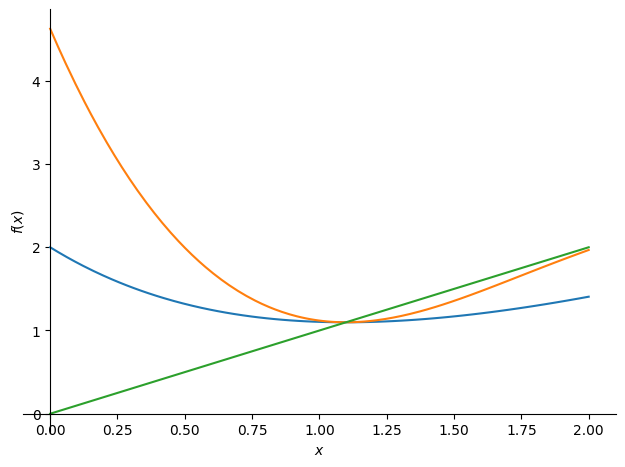

In [830]:
sp.plot(gNR(x),gSteff(x),x,(x,a,b));

In [831]:
yyNR = [gNR(x) for x in xx]

In [832]:
yySteff = [gSteff(x) for x in xx]

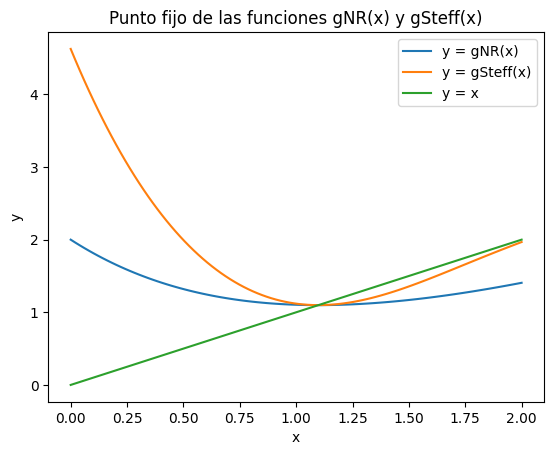

In [833]:
fig, ax = plt.subplots();
ax.plot(xx,yyNR, label = "y = gNR(x)");
ax.plot(xx,yySteff, label = "y = gSteff(x)");
ax.plot(xx,xx, label = "y = x");
ax.legend(loc=1);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Punto fijo de las funciones gNR(x) y gSteff(x)');

In [834]:
gNR(0),gNR(1),gNR(2.)

(2, -(-3 + E)*exp(-1) + 1, 1.40600584970984)

In [835]:
gSteff(0),gSteff(1),gSteff(2)

(-4/(-1 + exp(-2)),
 -(-3 + E)**2/(-E + exp(-2 + E)) + 1,
 -(-3 + exp(2))**2/(-exp(2) + exp(-1 + exp(2))) + 2)

In [836]:
x0 = sp.N(b); aproxNR = [x0]; niter = 1;
x1 = gNR(x0)
aproxNR.append(x1)
niter, aproxNR      # Esta sería la iteración inicial para aplicar el método de Newton-Raphson

(1, [2.00000000000000, 1.40600584970984])

In [837]:
x1 = gNR(x0); x0 = x1; niter = niter + 1;
aproxNR.append(x1)
niter, aproxNR
# Ahora bastará con que vuelvas a ejecutar esta misma celdilla varias veces seguidas para ir obteniendo manualmente
# las sucesivas iteraciones que proporciona el método de

(2, [2.00000000000000, 1.40600584970984, 1.40600584970984])

In [838]:
# Aquí ya estaría ya todo integrado en un bucle 'for'
x0 = sp.N(b); aproxNR = [x0]; niter = 10;
for k in range(niter):
    x1 = gNR(x0); x0 = x1
    aproxNR.append(x1)
print(aproxNR)

[2.00000000000000, 1.40600584970984, 1.14136698416535, 1.09951338303279, 1.09861269453172, 1.09861228866819, 1.09861228866811, 1.09861228866811, 1.09861228866811, 1.09861228866811, 1.09861228866811]


In [839]:
tol

1e-05

In [840]:
x0 = sp.N(b); maxiter = 100;
aproxNR = [x0]; niter = 0;
for k in range(maxiter):
    x1 = gNR(x0);
    aproxNR.append(x1); niter = niter + 1
    if abs(x1-x0) < tol: break
    x0 = x1
print(aproxNR)

[2.00000000000000, 1.40600584970984, 1.14136698416535, 1.09951338303279, 1.09861269453172, 1.09861228866819]


In [841]:
x0 = sp.N(b); maxiter = 100;
aproxSteff = [x0]; niter = 0;
for k in range(maxiter):
    x1 = gSteff(x0);
    aproxSteff.append(x1); niter = niter + 1
    if abs(x1-x0) < tol: break
    x0 = x1
print(aproxSteff)

[2.00000000000000, 1.96723313857337, 1.92867498801231, 1.88254691866007, 1.82635362143159, 1.75662328675511, 1.66877496993417, 1.55782574490399, 1.42216602519119, 1.27452887951491, 1.15530556035053, 1.10487131124589, 1.09869041430865, 1.09861230087490, 1.09861228866811]


In [842]:
x0 = b; aproxSteff = [x0]
x1 = gSteff(x0)
x1

-(-3 + exp(2))**2/(-exp(2) + exp(-1 + exp(2))) + 2

In [843]:
x0 = sp.N(b); aproxSteff = [x0]; niter = 0;
niter, aproxSteff          # Esta sería la iteración inicial para aplicar el método de Steffensen

(0, [2.00000000000000])

In [844]:
x1 = gSteff(x0); x0 = x1; niter = niter +1
aproxSteff.append(x1)
niter, aproxSteff
# Ahora bastará con que vuelvas a ejecutar esta misma celdilla varias veces seguidas para ir obteniendo manualmente
# las sucesivas iteraciones que proporciona el método de Steffensen

(1, [2.00000000000000, 1.96723313857337])

### Aceleración de la convergencia: métodos de Aitken y Steffensen

En el conocido método de Aitken se calcula una nueva sucesión de valores, $\left\{\hat{x_k}\right\}$, a partir de la original, $\left\{x_k\right\}$, mediante la fórmula siguiente:\\
$\quad \quad $$\hat{x_k}=x_k-\frac{\left(x_{k+1}-x_k\right){}^2}{x_{k+2}-2x_{k+1}+x_k}$

Veamos un ejemplo de aplicación de este método de aceleración, utilizando las iteraciones obtenidas previamente mediante el método
 equivalente al de Newton-Raphson.

In [845]:
aprox = aproxNR; print(aprox)
n = len(aprox)
n

[2.00000000000000, 1.40600584970984, 1.14136698416535, 1.09951338303279, 1.09861269453172, 1.09861228866819]


6

In [846]:
aprox[0]

2.00000000000000

In [847]:
k=0; aprox[k]
# aprox(k)-(aprox(k+1)-aprox(k))**2/(aprox(k+2)-2*aprox(k+1)+aprox(k))

2.00000000000000

In [848]:
k = 0; acelAitken = []; 
for k in range(n-2):
    aproxacel = aprox[k]-(aprox[k+1]-aprox[k])**2/(aprox[k+2]-2*aprox[k+1]+aprox[k])
    acelAitken.append(aproxacel); 
acelAitken

[0.928728133658494, 1.09165054734486, 1.09859288544553, 1.09861228848522]

Nótese la ligera mejora obtenida en muy pocas iteraciones. El hecho es que estos métodos de aceleración de la convergencia están
especialmente indicados para mejorar las iteraciones obtenidas por un método con convergencia lineal, en contra del caso del método de
Newton-Raphson para raíces simples, que sabemos que tiene convergencia cuadrática (recordemos que el método iterativo que estamos
empleando en este momento es el correspondiente a la aplicación del método de Newton-Raphson para funciones derivables).

En cuanto al método de aceleración de Steffensen, recuerde que se obtiene una nueva sucesión de valores, de tres en tres $\left\{\hat{x_0}{}^{(k)},\hat{x_1}{}^{(k)},\hat{x_2}{}^{(k)}\right\}$,
a partir de los tres primeros de la original, $\left\{x_0,x_1,x_2\right\}$, de la siguiente manera:\\
$\quad \quad $$\hat{x_0}{}^{(k+1)}=\hat{x_0}{}^{(k)}-\frac{\left(\hat{x_1}{}^{(k)}-\hat{x_0}{}^{(k)}\right){}^2}{\hat{x_2}{}^{(k)}-2\hat{x_1}{}^{(k)}+\hat{x_0}{}^{(k)}}$,
 $\hat{x_1}{}^{(k)}=g\left(\hat{x_0}{}^{(k)}\right)$,  $\hat{x_2}{}^{(k)}=g\left(\hat{x_1}{}^{(k)}\right)$, \\
siendo  $\left\{\hat{x_0}{}^{(0)},\hat{x_1}{}^{(0)},\hat{x_2}{}^{(0)}\right\}$=$\left\{x_0,g\left(x_0\right),g\left(x_1\right)\text{}\right\}$.

In [849]:
def g(x):
    return gNR(x)

In [850]:
acelSteff =[]
x0 = float(b); aproxtemp = [x0,g(x0),g(g(x0))]
aproxtemp

[2.0, 1.40600584970984, 1.14136698416535]

In [851]:
niteracelerado = 4
for i in range(niteracelerado):
    x0 = aproxtemp[0]-(aproxtemp[1]-aproxtemp[0])**2/(aproxtemp[2]-2*aproxtemp[1]+aproxtemp[0])
    aproxtemp = [x0,g(x0),g(g(x0))]
    acelSteff = acelSteff + [aproxtemp[-1]]
acelSteff

[1.09872848699195, 1.09861228866843, 1.09861228866811, 1.09861228866811]

In [852]:
# Esta sería otra variante de la aceleración de Steffensen menos eficiente,
# ya que se usan las aproximaciones originales, sin actualizar en cada paso
k = 0; acelSteff = []; 
for k in range(n-2):
    aproxSteff0 = aprox[k]-(aprox[k+1]-aprox[k])**2/(aprox[k+2]-2*aprox[k+1]+aprox[k])
    aproxSteff1 = g(aproxSteff0); aproxSteff2 = g(aproxSteff1);
    acelSteff.append(aproxSteff0); 
    acelSteff.append(aproxSteff1);
    acelSteff.append(aproxSteff2);
acelSteff

[0.928728133658494,
 1.11389568130288,
 1.09872848699195,
 1.09165054734486,
 1.09863657792169,
 1.09861228896309,
 1.09859288544553,
 1.09861228885635,
 1.09861228866811,
 1.09861228848522,
 1.09861228866811,
 1.09861228866811]

Como vemos, se obtienen resultados bastante aceptables, con muy pocas iteraciones.

### Órdenes directas de Python

### Resolución de ecuaciones en general

Aparte de todo esto *Python* también incorpora varias funciones y órdenes directas, o incluidas en alguno de los módulos más habituales, para aproximar los ceros de una función, ya sea de manera simbólica o bien mediante algoritmos de tipo bisección o Newton-Raphson, sin necesidad de acudir al código ya implementado anteriormente.

Entre éstas podemos indicar por ejemplo la orden `fsolve` del paquete `optimize` dentro del módulo `SciPy`.

Por ello, deberemos cargarlo mediante una orden como la siguiente:

    from scipy.optimize import fsolve
    
y habría que usarlo con el siguiente formato

    fsolve(f,x0)
    
donde la función f debe estar ya definida previamente y x0 es el valor inicial para comenzar las iteraciones.
 
En cuanto a las opciones disponibles, lo mejor es mirar la documentación disponible, preguntándole directamente al sistema Python para que nos muestre el docstring incluido en la definición de dicha orden

    ?fsolve

In [853]:
from scipy.optimize import fsolve

In [854]:
?fsolve

Signature:
fsolve(
    func,
    x0,
    args=(),
    fprime=None,
    full_output=0,
    col_deriv=0,
    xtol=1.49012e-08,
    maxfev=0,
    band=None,
    epsfcn=None,
    factor=100,
    diag=None,
)
Docstring:
Find the roots of a function.

Return the roots of the (non-linear) equations defined by
``func(x) = 0`` given a starting estimate.

Parameters
----------
func : callable ``f(x, *args)``
    A function that takes at least one (possibly vector) argument,
    and returns a value of the same length.
x0 : ndarray
    The starting estimate for the roots of ``func(x) = 0``.
args : tuple, optional
    Any extra arguments to `func`.
fprime : callable ``f(x, *args)``, optional
    A function to compute the Jacobian of `func` with derivatives
    across the rows. By default, the Jacobian will be estimated.
full_output : bool, optional
    If True, return optional outputs.
col_deriv : bool, optional
    Specify whether the Jacobian function computes derivatives down
    the columns (fa

In [855]:
# ahora nos interesará emplear la versión numérica de la función
# por lo que nos convendrá intercambiar la definición de f(x)
def f(x):
    '''Versión numérica de la función'''
    return fnum(x)

In [856]:
?f

Signature: f(x)
Docstring: Versión numérica de la función
File:      /tmp/ipykernel_213622/2095883551.py
Type:      function

In [857]:
fsolve(f, 1.0)

array([1.09861229])

In [858]:
_[0]     # recordamos que el guión bajo recupera la última salida del intérprete de IPython.

1.0986122886681096

Sin embargo, si lo que queremos es intentar obtener las soluciones exactas de cierto tipo de ecuaciones tendremos que hacerlo de manera simbólica, usando la orden `solve` perteneciente al módulo `SymPy`. También existe su versión numérica `nsolve`, que intenta aproximar la más cercana al valor de la variable que introduzcamos.

Ambas deberemos cargarlas de la siguiente forma

    from sympy.solvers import solve, nsolve

aparte de poder definir las variables simbólicas que necesitemos

    from sympy import Symbol
    x = Symbol('x')
    
Veámos algunos ejemplos a continuación, pero convendría consultar parte de la documentación online al respecto para poder revisar todas las opciones de la orden [solve](http://docs.sympy.org/0.7.1/modules/solvers/solvers.html), aunque progresivamente ésta se está sustituyendo cada vez más por su versión [solveset](https://github.com/scipy-lectures/scipy-lecture-notes/issues/308), que también admite inecuaciones del tipo: `solveset(exp(x) > 1, x, R)`

Otra versión más numérica de esta orden sería [nsolve](http://nullege.com/codes/search/sympy.solvers.nsolve?fulldoc=1).

También podemos consultar la documentación incluida en el docstring de cada una de estas órdenes preguntándole directamente a Python, sin más que anteponer el signo de interrogación, como ya sabemos.

In [859]:
from sympy.solvers import solve, nsolve, solveset
import sympy as sp

In [860]:
?solve

Signature: solve(f, *symbols, **flags)
Docstring:
Algebraically solves equations and systems of equations.

Explanation

Currently supported:
    - polynomial
    - transcendental
    - piecewise combinations of the above
    - systems of linear and polynomial equations
    - systems containing relational expressions

Examples

The output varies according to the input and can be seen by example:

    >>> from sympy import solve, Poly, Eq, Function, exp
    >>> from sympy.abc import x, y, z, a, b
    >>> f = Function('f')

Boolean or univariate Relational:

    >>> solve(x < 3)
    (-oo < x) & (x < 3)


To always get a list of solution mappings, use flag dict=True:

    >>> solve(x - 3, dict=True)
    [{x: 3}]
    >>> sol = solve([x - 3, y - 1], dict=True)
    >>> sol
    [{x: 3, y: 1}]
    >>> sol[0][x]
    3
    >>> sol[0][y]
    1


To get a list of *symbols* and set of solution(s) use flag set=True:

    >>> solve([x**2 - 3, y - 1], set=True)
    ([x, y], {(-sqrt(3), 1), (sqrt(3), 1

In [861]:
?nsolve

Signature: nsolve(*args, dict=False, **kwargs)
Docstring:
Solve a nonlinear equation system numerically: ``nsolve(f, [args,] x0,
modules=['mpmath'], **kwargs)``.

Explanation

``f`` is a vector function of symbolic expressions representing the system.
*args* are the variables. If there is only one variable, this argument can
be omitted. ``x0`` is a starting vector close to a solution.

Use the modules keyword to specify which modules should be used to
evaluate the function and the Jacobian matrix. Make sure to use a module
that supports matrices. For more information on the syntax, please see the
docstring of ``lambdify``.

If the keyword arguments contain ``dict=True`` (default is False) ``nsolve``
will return a list (perhaps empty) of solution mappings. This might be
especially useful if you want to use ``nsolve`` as a fallback to solve since
using the dict argument for both methods produces return values of
consistent type structure. Please note: to keep this consistent with
``solve

In [862]:
?solveset

Signature: solveset(f, symbol=None, domain=Complexes)
Docstring:
Solves a given inequality or equation with set as output

Parameters

f : Expr or a relational.
    The target equation or inequality
symbol : Symbol
    The variable for which the equation is solved
domain : Set
    The domain over which the equation is solved

Returns

Set
    A set of values for `symbol` for which `f` is True or is equal to
    zero. An :class:`~.EmptySet` is returned if `f` is False or nonzero.
    A :class:`~.ConditionSet` is returned as unsolved object if algorithms
    to evaluate complete solution are not yet implemented.

``solveset`` claims to be complete in the solution set that it returns.

Raises

NotImplementedError
    The algorithms to solve inequalities in complex domain  are
    not yet implemented.
ValueError
    The input is not valid.
RuntimeError
    It is a bug, please report to the github issue tracker.


Notes
=====

Python interprets 0 and 1 as False and True, respectively, but
i

In [863]:
from sympy import Symbol
x = Symbol('x')

In [864]:
solve( x**2 - 1, x )  # he aquí un simple ejemplo de uso
# vemos que devuelve las soluciones en forma de lista

[-1, 1]

In [865]:
solve( x**2 - 1, x, dict = True  )  # aquí vemos que también 
# podemos hacer que devuelva las soluciones en forma de diccionario

[{x: -1}, {x: 1}]

In [866]:
solveset( x**2 - 1, x )  # he aquí un simple ejemplo de uso
# vemos que devuelve las soluciones en forma de conjunto

{-1, 1}

In [867]:
solveset( x**2 - 1, x)  # he aquí un simple ejemplo de uso
# vemos que devuelve las soluciones en forma de conjunto

{-1, 1}

In [868]:
# También podemos pedirle que resuelva inecuaciones
solveset(sp.exp(x) > 1, x, domain=sp.S.Reals)

Interval.open(0, oo)

In [869]:
solve(sp.sin(x)*sp.cos(x),x)  # ejemplo con funciones trigonométricas
# aunque en estos casos es evidente que no se pueden obtener a la vez
# las infinitas soluciones

[0, pi/2, pi, 3*pi/2]

In [870]:
nsolve(sp.sin(x)*sp.cos(x), x, 1 ) # sin embargo con nsolve podemos ir
# aproximando numéricamente las más cercanas al valor de x introducido

1.57079632679490

In [871]:
nsolve(sp.sin(x)*sp.cos(x), 3 ) # sin embargo con nsolve podemos ir
# aproximando numéricamente las más cercanas al valor de x introducido

3.14159265358979

In [872]:
a = sp.Symbol('a')

In [873]:
solve(1/a*sp.exp(x+1)-3*a**2,x)

[log(a**3) - 1 + log(3)]

Veamos algunos ejemplos más:

In [874]:
# solve((1-sp.sqrt(x))/x**2 - sp.sqrt(x-1),x) 
# Se ha dejado comentada la linea anterior para no interrumpir el flujo de ejecución del notebook

In [875]:
# solveset((1-sp.sqrt(x))/x**2 - sp.sqrt(x-1),x)
# Se ha dejado comentada la linea anterior para no interrumpir el flujo de ejecución del notebook

Aquí vemos como no es capaz de calcular todas las soluciones de la ecuación; sino que muchas de ellas las tendría que dejar indicadas, resultando ser los ceros del siguiente polinomio  $ -1+x-2x^4-2x^5-x^8+x^9$ que veremos en la siguiente sección cómo se pueden calcular mediante
una sentencia propia para estos casos.

In [876]:
nsolve((1-sp.sqrt(x))/x**2 - sp.sqrt(x-1),x,1)   # así podemos ir aproximando una a una

1.00000000000000

In [877]:
nsolve((1-sp.sqrt(x))/x**2 - sp.sqrt(x-1),x,2)   # indicando un valor inicial adecuado
# vemos que también es capaz de obtener aproximaciones de las raíces complejas

-0.346456825757401 - 0.785428138804099*I

In [878]:
nsolve((1-sp.sqrt(x))/x**2 - sp.sqrt(x-1),x,3)   # indicando un valor inicial adecuado
# vemos que también es capaz de obtener aproximaciones de las raíces complejas

-0.346456825757401 + 0.785428138804099*I

### Resolución de ecuaciones polinómicas con Python

La orden de NumPy  `roots` obtiene todas las raíces reales y complejas de la ecuación polinómica $a_nx^n+...+a_2x^2+a_1x+a_0=0$ correspondiente a los coeficientes $[a_n, ..., a_2,a_1, a_0]$ guardados en una lista con las mismas tal y como se observa  en el siguiente ejemplo:

In [879]:
coefs = [3.2,1,2]
np.roots(coefs)

array([-0.15625+0.7749748j, -0.15625-0.7749748j])

In [880]:
coefs = [1,1,0,0,-2,-2,1,-1]
np.roots(coefs)

array([-1.27308945+0.36784131j, -1.27308945-0.36784131j,
       -0.08811871+1.23334263j, -0.08811871-1.23334263j,
        1.18028373+0.j        ,  0.27106629+0.49202862j,
        0.27106629-0.49202862j])

Observe ahora la salida de las dos órdenes siguientes:

In [881]:
solve((x**2+9)*(x-2.5),x)

[2.50000000000000, -3.0*I, 3.0*I]

In [882]:
sp.expand((x**2+9)*(x-2.5))

x**3 - 2.5*x**2 + 9*x - 22.5

In [883]:
coefs = [1,-2.5,9,-22.5]
np.roots(coefs)

array([4.4408921e-16+3.j, 4.4408921e-16-3.j, 2.5000000e+00+0.j])

In [884]:
solve(x**4-3*x**3+x,x)

[0,
 1 + (-1/2 - sqrt(3)*I/2)*(1/2 + sqrt(3)*I/2)**(1/3) + 1/((-1/2 - sqrt(3)*I/2)*(1/2 + sqrt(3)*I/2)**(1/3)),
 1 + 1/((-1/2 + sqrt(3)*I/2)*(1/2 + sqrt(3)*I/2)**(1/3)) + (-1/2 + sqrt(3)*I/2)*(1/2 + sqrt(3)*I/2)**(1/3),
 1 + (1/2 + sqrt(3)*I/2)**(-1/3) + (1/2 + sqrt(3)*I/2)**(1/3)]

In [885]:
coefs = [1,-3,0,1,0]
np.roots(coefs)

array([ 2.87938524,  0.65270364, -0.53208889,  0.        ])

In [886]:
coefs = [1,0,0,0,0,0,9,0,0,0,0,0,0,4,0,0,0,0,2,-25]
np.roots(coefs)

array([-1.26214937+0.72204368j, -1.26214937-0.72204368j,
       -0.01351472+1.44441574j, -0.01351472-1.44441574j,
       -1.05513865+0.22785245j, -1.05513865-0.22785245j,
       -0.79138667+0.75559469j, -0.79138667-0.75559469j,
       -0.39375893+0.98759052j, -0.39375893-0.98759052j,
        0.17201633+1.09344096j,  0.17201633-1.09344096j,
        1.23432741+0.72254909j,  1.23432741-0.72254909j,
        0.59019389+0.86714166j,  0.59019389-0.86714166j,
        0.99794517+0.50359311j,  0.99794517-0.50359311j,
        1.04293108+0.j        ])

In [887]:
solve(x**5+x-1,x)

[1/2 - sqrt(3)*I/2,
 1/2 + sqrt(3)*I/2,
 -1/3 + (-1/2 - sqrt(3)*I/2)*(sqrt(69)/18 + 25/54)**(1/3) + 1/(9*(-1/2 - sqrt(3)*I/2)*(sqrt(69)/18 + 25/54)**(1/3)),
 -1/3 + 1/(9*(-1/2 + sqrt(3)*I/2)*(sqrt(69)/18 + 25/54)**(1/3)) + (-1/2 + sqrt(3)*I/2)*(sqrt(69)/18 + 25/54)**(1/3),
 -1/3 + 1/(9*(sqrt(69)/18 + 25/54)**(1/3)) + (sqrt(69)/18 + 25/54)**(1/3)]

In [888]:
coefs = [1,0,0,0,1,-1]
np.roots(coefs)

array([-0.87743883+0.74486177j, -0.87743883-0.74486177j,
        0.5       +0.8660254j ,  0.5       -0.8660254j ,
        0.75487767+0.j        ])

# Resolución de sistemas de ecuaciones no lineales

   No cabe duda de que en muchas ocasiones también tendremos que resolver sistemas de ecuaciones no lineales y no sólo una ecuación escalar, para la que ya hemos visto bastantes métodos efectivos en la primera parte de este notebook. 

   Ahora nos proponemos indicar también algunas posibilidades cuando se trate más bien de sistemas de ecuaciones no lineales, para las que no siempre habrá posibilidad de obtener soluciones exactas, ni tampoco existen procedimientos o algoritmos sistemáticos, como sí que los hay para el caso de sistemas lineales. No obstante, sí que disponemos de generalizaciónes adecuadas de alguno de los métodos numéricos que ya se tenían para el caso escalar y que nos permitirán al menos aproximar numéricamente, con un cierto grado de precisión determinado, dichas soluciones, en caso de que estas existan.

## Probemos primero analíticamente

In [889]:
from sympy import symbols, Eq, solve
# from sympy import init_printing  
# init_printing()
# esta opción ya no es necesaria

In [890]:
x, y = symbols('x, y')

In [891]:
eq1 = Eq(x + y**2, 4)
eq2 = Eq(x**2 + y, 4)

In [892]:
eq1

Eq(x + y**2, 4)

In [893]:
eq2

Eq(x**2 + y, 4)

In [894]:
sols = solve([eq1, eq2], [x,y])
sols

[(-(-5/2 - sqrt(17)/2)*(3/2 - sqrt(17)/2), -sqrt(17)/2 - 1/2),
 (-(-5/2 + sqrt(17)/2)*(3/2 + sqrt(17)/2), -1/2 + sqrt(17)/2),
 (-(-3/2 + sqrt(13)/2)*(sqrt(13)/2 + 5/2), 1/2 + sqrt(13)/2),
 (-(5/2 - sqrt(13)/2)*(-sqrt(13)/2 - 3/2), 1/2 - sqrt(13)/2)]

In [895]:
# from sympy import init_printing
# init_printing()
sols    # en caso de que se quiera obtener las soluciones con un formato
# más vistoso (tipo LaTeX) descomentar las dos lineas anteriores

[(-(-5/2 - sqrt(17)/2)*(3/2 - sqrt(17)/2), -sqrt(17)/2 - 1/2),
 (-(-5/2 + sqrt(17)/2)*(3/2 + sqrt(17)/2), -1/2 + sqrt(17)/2),
 (-(-3/2 + sqrt(13)/2)*(sqrt(13)/2 + 5/2), 1/2 + sqrt(13)/2),
 (-(5/2 - sqrt(13)/2)*(-sqrt(13)/2 - 3/2), 1/2 - sqrt(13)/2)]

## Resolución numérica aproximada

In [896]:
from scipy.optimize import fsolve
from sympy import symbols, exp, nsolve

In [897]:
x, y = symbols('x, y')
def equations(p):
    x, y = p

    return (x + y**2 - 4, exp(x) + x*y -3)

In [898]:
equations((x,y))

(x + y**2 - 4, x*y + exp(x) - 3)

In [899]:
# vemos que la expresión algebraica de estas ecuaciones es independiente 
u,v = symbols('u,v')    # de las variables concretas que se usen
equations((u,v))

(u + v**2 - 4, u*v + exp(u) - 3)

In [900]:
# Veámos ahora cómo obtener las soluciones numéricas de dicho sistema de ecuaciones
nsolve(equations((x,y)), [x,y],[1,1])

Matrix([
[0.620344523485226],
[ 1.83838393066159]])

In [901]:
# cuyas soluciones también se pueden obtener con una precisión arbitraria
nsolve(equations((x,y)), [x,y],[1,1], prec = 50)

Matrix([
[0.62034452348522585617392716579154399314071550594401],
[  1.838383930661594459049793153371142549403114879699]])

In [902]:
# También podríamos haber usado la orden fsolve del módulo Scipy.optimize
x0, y0  = (1,1)   # indicando un par de valores iniciales para comenzar
x, y    = fsolve(equations, (x0,y0)) # con el método iterativo correspondiente.

In [903]:
print(x,y)    # Esta sería la aproximación de dichas soluciones numéricas

0.6203445234801195 1.8383839306750887


In [904]:
# comprobamos además que al evaluar estas expresiones algebraicas en las soluciones aproximadas
print(equations((x,y)))   # obtenidas previamente obtenemos valores bastante próximos a cero.

(4.4508396968012676e-11, -1.05120356863608e-11)


In [905]:
print("Final de la práctica")

Final de la práctica


## Ejercicios

1.- Demuestre que la ecuación  $x^3+4 x^2=10  $  tiene una única raíz en el intervalo $[1,2]$.  Aproxime dicha raíz con el método de bisección con al menos 3 cifras decimales exactas. ¿Cuántas iteraciones serán necesarias para conseguir 5 cifras decimales exactas (tol =$10^{-5}$)?  Aproxime también la raíz con el método de Newton-Raphson partiendo del extremo adecuado hasta que la diferencia en valor absoluto, entre dos aproximaciones consecutivas sea  inferior a  $10^{-3}$.

2.- Encuentre una aproximación de la raíz cúbica de 25 con dos decimales exactos (tol =$10^{-2}$), usando el algoritmo de bisección.

3.- Use el método de Newton-Raphson para aproximar las soluciones de las siguientes ecuaciones con tolerancia $10^{-5}$ , partiendo de un valor adecuado, próximo a cada una de ellas en cada caso.

i) $x^3-x-1 = 0$  en $[1,2]$.

ii) $3x=2+x^2-e^x$.

iii) $x^2+10\, cos x+x=0$.

4.- Para la función  $ f(x)= 3 x^2+e^x-1$, 

i) encuentre, mediante el método de bisección una aproximación de la raíz en $[0,1]$ con, al menos, cuatro decimales exactos (tol =$10^{-4}$), y determine el número de iteraciones realizadas;

ii) encuentre, mediante el método de Newton-Raphson, una aproximación de la raíz en $[0,1]$ con una tolerancia de $10^{-4}$, partiendo de $x_0=0$, y determine el número de iteraciones realizadas.  

5.- Utilice las órdenes apropiadas de Python para aproximar todos los puntos donde se anulan las funciones siguientes (si es necesario, represéntelas gráficamente):

i) $f(x)=x^7-x^4+2$ ,

ii) $f(x)=x^7+\cos  x-3$.

 6.- Aplicar los métodos de aceleración de la convergencia de Aitken y Steffensen (según los apuntes) a las sucesiones obtenidas para los distintos métodos programados en esta práctica y comparar los resultados. Para aplicar el método de aceleración de Steffensen, recuerde que para transformar cualquier ecuación de la forma  $ f(x)=0 $  en un problema de puntos fijos  $ g(x)=x $, la forma más simple puede ser definir  $g(x)=x \pm f(x)$.

 7.- Programar el método de Newton-Raphson acelerado, partiendo de cierto $x_0$ adecuado: $$x_{n+1}=x_n - m\frac{f(x_n)}{f'(x_n)}, \quad n=0,1,2,\ldots$$ para el caso de una raíz múltiple (de multiplicidad $m\in\mathbb{N}$) de una ecuación del tipo $f(x)=0$ y comparar los resultados
con los que se obtienen mediante el empleo de los métodos de aceleración habituales de Aitken y Steffensen (según los apuntes).

 8.- Programar el conocido algoritmo de Horner para la evaluación de un polinomio y emplearlo de forma reiterativa para el cálculo del desarrollo de Taylor de orden $ n$ de un polinomio cualquiera. Aprovecharlo también para programar una versión especial del método de Newton-Raphson para polinomios, evaluando tanto  $ p(x_k ) $ como $ p'(x_k)$ mediante el citado algoritmo y aplicarlo para aproximar alguna de las raíces reales del siguiente polinomio

$$p(x)=d_0 + d_1 x + d_2 x^2 + d_3 x^3+ d_4 x^4 + d_5 x^5 + d_6 x^6 + d_7 x^7 $$
(siendo $d_0, d_1, \ldots, d_7$ los dígitos ordenados de su DNI, pasaporte o tarjeta de residente).

Programar y construir también una sucesión de Sturm para dicho polinomio.